### Exploración de datos (EDA)

In [8]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../dataset/drug.csv")
df = pd.read_csv(DATA_PATH)

display(df.head())

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [ ]:
df.shape #Filas x Columnas

(200, 6)

In [10]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    str    
 2   BP           200 non-null    str    
 3   Cholesterol  200 non-null    str    
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    str    
dtypes: float64(1), int64(1), str(4)
memory usage: 9.5 KB


#### Resumen estadistico de las columnas
(numericas y categoricas)

In [ ]:
df.describe(include="all").T
#.T transpone la tabla y deja las columnas como filas

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,200.0,NaN,NaN,NaN,44.315,16.544315,15.0,31.0,45.0,58.0,74.0
Sex,200,2,M,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP,200,3,HIGH,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cholesterol,200,2,HIGH,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Na_to_K,200.0,NaN,NaN,NaN,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247
Drug,200,5,DrugY,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df.isna().sum().sort_values(ascending=False).to_frame("missing_values")
# .isna marca cada celda como True si esta vacia (NaN)
# .sum suma los True (NaN) por columna
# .sort_values ordena de mayor a menor
# .to_frame convierte los nuevos resultados "faltantes" a un df de una columna

,missing_values
Age,0
Sex,0
BP,0
Cholesterol,0
Na_to_K,0
Drug,0


#### Siguientes pasos:
1. Revisamos la variable objetivo `Drug`
2. Revisamos las variables categóricas por clase (presion arterial, colesterol, sodio/potasio)
3. Revisamos las variables numéricas y valores atípicos (outliers)
4. Revisamos la relación entre variables numéricas vs objetivo
5. Transformamos para hacer el modelado

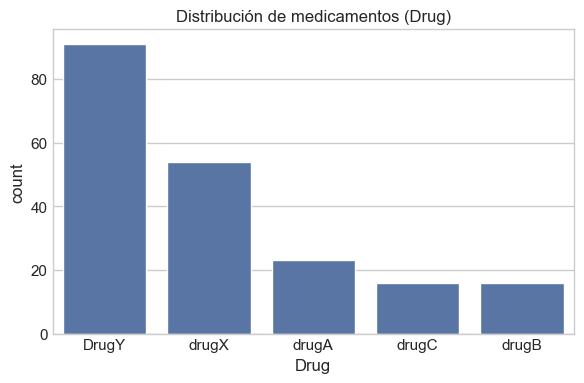

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# 1) Revisamos la variable objetivo
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Drug", order=df["Drug"].value_counts().index)
plt.title("Distribución de medicamentos (Drug)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Conclusion:
- Drug esta desbalanceada ya que DrugY domina, lo que puede significar que nuestro modelo prediga mas la clase mayoritaria.

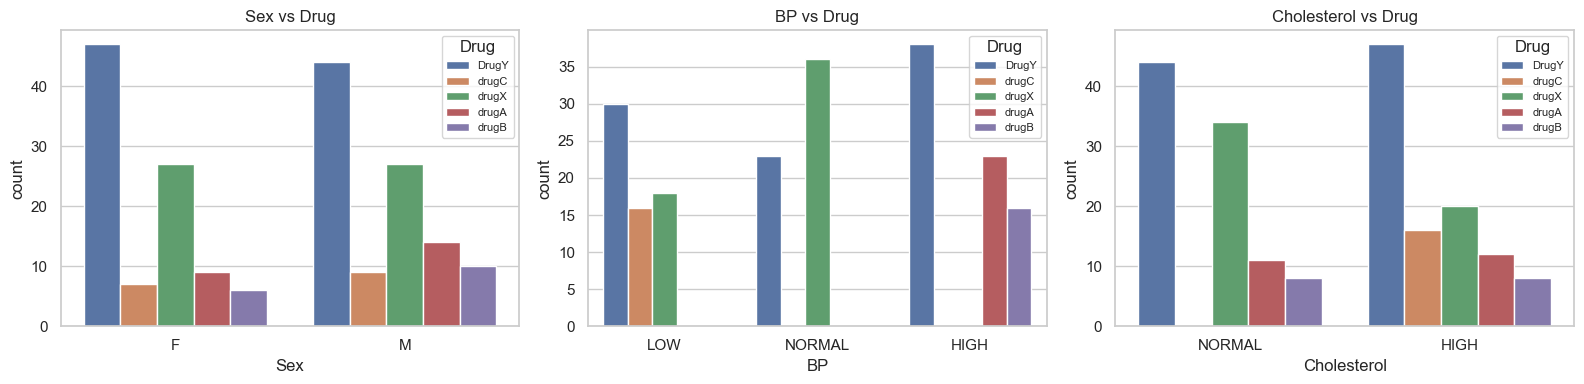

In [ ]:
# 2) Revisamos las variables categóricas por clase
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.countplot(data=df, x="Sex", hue="Drug", ax=axes[0])
axes[0].set_title("Sex vs Drug")

sns.countplot(data=df, x="BP", hue="Drug", ax=axes[1], order=["LOW", "NORMAL", "HIGH"])
axes[1].set_title("BP vs Drug")

sns.countplot(data=df, x="Cholesterol", hue="Drug", ax=axes[2], order=["NORMAL", "HIGH"])
axes[2].set_title("Cholesterol vs Drug")

for ax in axes:
    ax.legend(title="Drug", fontsize=8)

plt.tight_layout()
plt.show()

Conclusion:
- Tabla Sex no parece ser la variable más determinante por sí sola; en ambos sexos aparecen varias clases de Drug.
- Tabla BP (blood pressure) sí muestra una señal fuerte de que las clases de medicamento cambian según el nivel de presion arterial.
- Tabla Cholesterol tambien se separa con base a la distribución de Drug (NORMAL vs HIGH).

Interpretacion final:
* DrugY es la clase de medicamento dominante entre varios grupos, y la decision del medicamento depende mas de la combinacion de variables categoricas (BP, Cholesterol y Na_to_K) que el sexo.

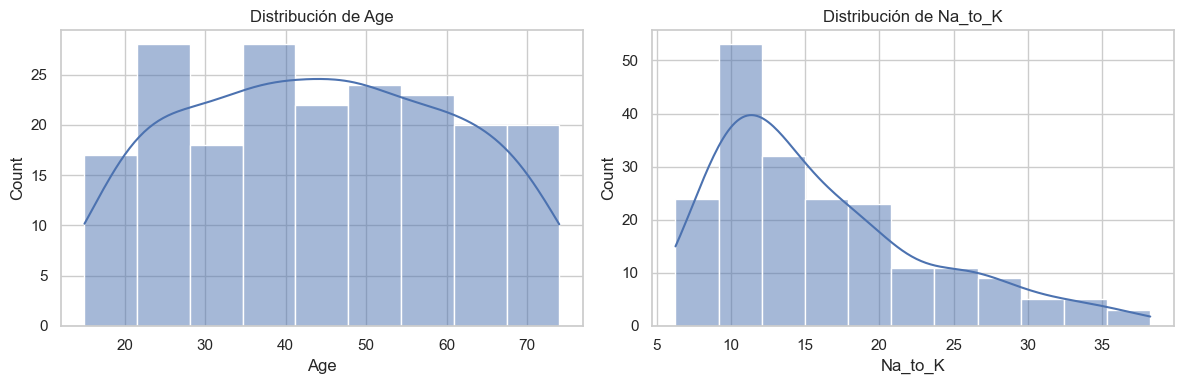

In [ ]:
# 3) Revisamos las variables numéricas y valores atípicos (outliers)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["Age"], kde=True, ax=axes[0])
axes[0].set_title("Distribución de Age")

sns.histplot(df["Na_to_K"], kde=True, ax=axes[1])
axes[1].set_title("Distribución de Na_to_K")

plt.tight_layout()
plt.show()

Conclusion:
- Tabla Age se ve relativamente distribuida de forma amplia y sin picos extremos muy marcados.
- Tabla Na_to_K muestra más valores altos indicando algunos casos con ratios mayores al promedio.

Interpretacion final:
* Na_to_K tiene algo de variabilidad, lo que significa que puede ser una variable muy informativa para separar clases de medicamentos.

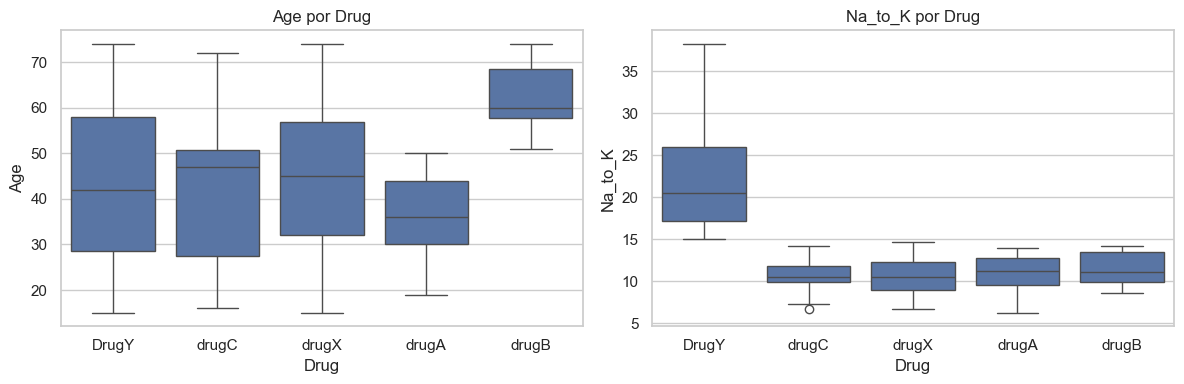

In [ ]:
# 4) Revisamos la relación entre variables numéricas vs objetivo
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=df, x="Drug", y="Age", ax=axes[0])
axes[0].set_title("Age por Drug")

sns.boxplot(data=df, x="Drug", y="Na_to_K", ax=axes[1])
axes[1].set_title("Na_to_K por Drug")

plt.tight_layout()
plt.show()

Conclusion:

- Tabla Na_to_K separa mejor las clases que la tabla Age.
- DrugY tiende a valores más altos de Na_to_K.
- Age muestra que los rangos de valores entre clases de mezclan, lo que puede significar que pacientes con medicamentos diferentes puedan tener edades parecidas. Esto no ayuda tanto al modelado para diferenciar medicamentos.

Interpretacion final:
* Los niveles de Sodio/Potasio son clave para el modelado.


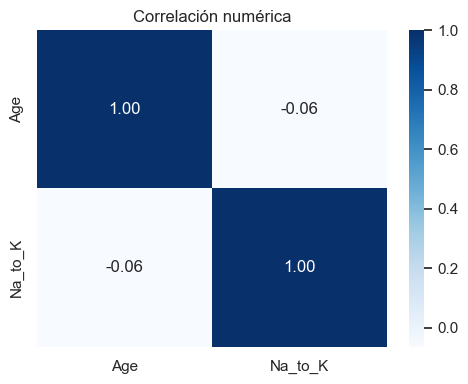

In [ ]:
# Correlación entre variables numéricas
plt.figure(figsize=(5, 4))
num_cols = ["Age", "Na_to_K"]
sns.heatmap(df[num_cols].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlación numérica")
plt.tight_layout()
plt.show()

Conclusion:
- La correlación entre Age y Na_to_K es muy débil.
- No hay multicolinealidad relevante entre esas dos variables.
- Si bien aportan informacion distinta, para el modelado es importante mantener ambas ya que se complementan informativamente.

### Modelo (Random Forest)

Entrenamos el modelo y revisamos métricas como:
- Accuracy
- Precision, Recall y F1-score por clase
- Matriz de confusión

In [34]:
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

feature_columns = ["Age", "Sex", "BP", "Cholesterol", "Na_to_K"]
target_column = "Drug"

X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

preprocess = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), ["Sex", "BP", "Cholesterol"]),
        ("numeric", "passthrough", ["Age", "Na_to_K"]),
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("classifier", RandomForestClassifier(n_estimators=300, random_state=42)),
    ]
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9750

Reporte de clasificación:
              precision    recall  f1-score   support

       DrugY       0.95      1.00      0.97        18
       drugA       1.00      1.00      1.00         5
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         3
       drugX       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40



Conclusion:
- Accuracy alto (97%) que nos muestra un muy buen desempeño
- DrugA, drugB y drugC fueron predichas al 100% (precision, recall y f1-score de 1.00)
- DrugY que es la mayoritaria, obtuvo una muy buena precision (95%)
- DrugX tiene mas errores, lo que significa que algunos ejemplos fueron clasificados como otra clase.

#### Matriz de confusion:
Tabla de "contingencia" para saber exactamente en que clases acierta y en cuales se equivoca el modelo

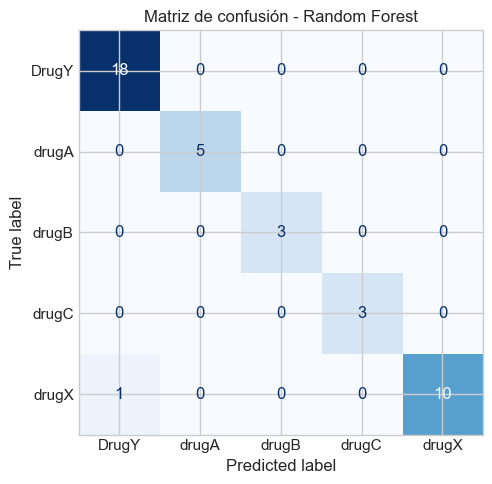

In [36]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Matriz de confusión - Random Forest")
plt.tight_layout()
plt.show()

Conclusion:
- La mayoría de las predicciones del modelo son correctas (valores altos en la diagonal).
- Las clases drugA, drugB y drugC no presentan errores: todos sus ejemplos fueron correctamente clasificados.
- Para DrugY, el modelo acierta en casi todos los casos.
- La clase drugX es la que más errores presenta: algunos de sus ejemplos fueron clasificados como DrugY.
- No hay errores graves de confusión entre clases minoritarias, lo que indica que el modelo distingue bien entre ellas.


Interpretacion final:
- El modelo Random Forest tiene un desempeño muy alto, con la mayoría de los errores concentrados en la distinción entre drugX y DrugY.